<a href="https://colab.research.google.com/github/iamviji/project/blob/master/MainModelModCoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 128 (delta 51), reused 16 (delta 2), pack-reused 0
Receiving objects: 100% (128/128), 2.09 MiB | 2.81 MiB/s, done.
Resolving deltas: 100% (51/51), done.
project  sample_data
MainModel.ipynb		     MainModelOneHotMethodSoftMax.ipynb
MainModelKeras.ipynb	     MainModelWithSingleBERTraining.ipynb
MainModelKerasOneHot.ipynb   README.md
MainModelModCoding.ipynb     util.py
MainModelOneHotMethod.ipynb
     |████████████████████████████████| 1.1MB 2.8MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=7ee46652b35784f9393162017fe2d62cdd7a6bea6fdbc160971517c4db911eea
  Stored in directory: /root/.cache/pip/wheels/47/7a/10/e94058ba8b0b6d98bf2719226d18d3dd6056525ad7b984c068
Successfully built pyldpc
     |████████████████████████████████| 51kB 1.5MB/s 


In [2]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [4]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [5]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[0 0 0 ... 0 1 0]
 [1 0 0 ... 1 1 1]
 [1 0 0 ... 0 1 0]
 ...
 [1 0 1 ... 1 0 1]
 [1 0 0 ... 0 1 1]
 [1 0 0 ... 1 0 1]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [6]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.53s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.99s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.50s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.98s
SNR: 0.000:
 -> BER: 0.63
 -> Total Time: 15.00s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.48s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.75s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.03s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.24s
SNR: 0.500:
 -> BER: 0.56
 -> Total Time: 13.50s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.98s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.07s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.28s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.35s
SNR: 1.000:
 -> BER: 0.47
 -> Total Time: 10.67s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.89s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.72s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [7]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.25s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.63s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.13s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.48s
SNR: 0.000:
 -> BER: 0.61
 -> Total Time: 13.49s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.21s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.43s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.52s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 4.70s
SNR: 0.500:
 -> BER: 0.55
 -> Total Time: 11.86s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.88s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.87s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 3.77s
SNR: 1.000:
 -> BER: 0.43
 -> Total Time: 9.56s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.72s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.60s
SNR: 1.500 - Iter: 750 - Last 250.0 ite

In [8]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.29s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.82s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.20s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.50s
SNR: 0.000:
 -> BER: 0.62
 -> Total Time: 13.81s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.12s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.21s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.26s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 4.33s
SNR: 0.500:
 -> BER: 0.53
 -> Total Time: 10.92s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.97s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.92s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.89s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 3.86s
SNR: 1.000:
 -> BER: 0.47
 -> Total Time: 9.64s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.70s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.50s
SNR: 1.500 - Iter: 750 - Last 250.0 ite

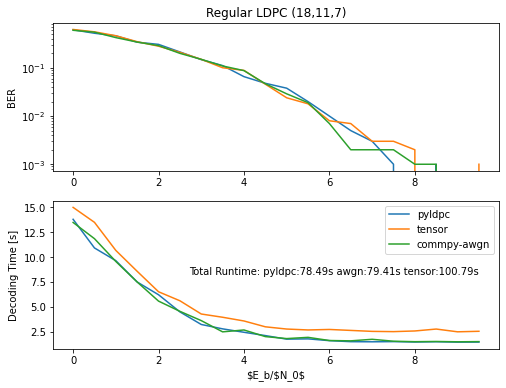

In [9]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [200]:
# Define Model 

# input_message_length is initialized by ldpc encoder
CHANNEL_SIZE=2
input_message_length = 4
num_hidden_1 = CHANEL_SIZE
print ("input_message_length=", input_message_length)

input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, CHANEL_SIZE], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, num_hidden_1], -1, 1), name="encoder_l1_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length, input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l1_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  #layer_2 = tf.round(layer_1)
  
  layer_2 =  layer_1 / tf.sqrt(tf.reduce_mean(tf.square(layer_1)))

  #x = tf.sqrt(tf.reduce_sum(tf.square(layer_1), axis=1))
  #x = tf.reshape (x, (-1,1))
  #layer_2 = layer_1 / x

  #layer_2 =  tf.nn.relu(layer_1)
  return layer_2

#input_channel_x = tf.placeholder("float32", [None, 3], name="input_channel_x")
#x = tf.sqrt(tf.reduce_sum(tf.square(input_channel_x), axis=1))
#x = tf.reshape(x, (-1, 1))
#l = x
#l = input_channel_x / x
def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = tf.nn.sigmoid (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
lr = tf.placeholder(dtype=tf.float32,shape=[])
rms_optimizer = tf.train.AdamOptimizer(learning_rate=0.00007).minimize (loss1)
rms_optimizer1 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize (loss1)


awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

input_message_length= 4


In [201]:
class GetOutOfLoop( Exception ):
    pass
batch_size = 50
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 20
outer_ephocs = 1
display_step = epochs/2
num_of_batches = len(training_input_message) / batch_size
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1

try:
  for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
    sigma = 1.0*Snr2Sigma (7)
    print ("Training for SNR=", snr, " sigma=", sigma) 
    if (snr < 6): opt = rms_optimizer1
    else : opt = rms_optimizer 
    for e in range(epochs):
      for j in range (int(num_of_batches)):
        x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
        x_train_batch_float = x_train_batch.astype("float32")
        _, l = train_sess.run ([opt, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev_x:sigma, lr:lrate})
        if (l < 0.5): lrate = 0.001
        if (l < 0.25): lrate = 0.00001
        if (l < 0.1): lrate = 0.000001
        if (l < 0.07): lrate = 0.0000001
        if j % display_step == 0:
          print('Step %i: Minibatch Loss: %f' % (i*display_step+j, l))
        if (l < 0.0005): raise GetOutOfLoop
except GetOutOfLoop:
  print("Early Stop")

Streaming output truncated to the last 5000 lines.
Step 20120: Minibatch Loss: 0.038327
Step 20130: Minibatch Loss: 0.038485
Step 20140: Minibatch Loss: 0.038013
Step 20150: Minibatch Loss: 0.038066
Step 20160: Minibatch Loss: 0.038282
Step 20170: Minibatch Loss: 0.038285
Step 20180: Minibatch Loss: 0.038339
Step 19990: Minibatch Loss: 0.038221
Step 20000: Minibatch Loss: 0.038505
Step 20010: Minibatch Loss: 0.038018
Step 20020: Minibatch Loss: 0.037769
Step 20030: Minibatch Loss: 0.037794
Step 20040: Minibatch Loss: 0.038003
Step 20050: Minibatch Loss: 0.038727
Step 20060: Minibatch Loss: 0.037931
Step 20070: Minibatch Loss: 0.038054
Step 20080: Minibatch Loss: 0.037779
Step 20090: Minibatch Loss: 0.037698
Step 20100: Minibatch Loss: 0.037861
Step 20110: Minibatch Loss: 0.038038
Step 20120: Minibatch Loss: 0.037464
Step 20130: Minibatch Loss: 0.037504
Step 20140: Minibatch Loss: 0.037209
Step 20150: Minibatch Loss: 0.037444
Step 20160: Minibatch Loss: 0.037608
Step 20170: Minibatch Lo

In [195]:
#a = [[1,2],[3,4]]
#x=a/numpy.sqrt(numpy.sum(numpy.square(a),axis=1).reshape([2,1]))
#print (x)
#print (1/numpy.sqrt(5))
#print (x[0][0]**2+x[0][1]**2)

#input_channel_x = tf.placeholder("float32", [None, 2], name="input_channel_x")
#x = tf.sqrt(tf.reduce_sum(tf.square(input_channel_x), axis=1))
#x = tf.reshape(x, (-1, 1))
#l = x
#l = input_channel_x / x

#ans=train_sess.run ([l], feed_dict={input_channel_x:a})
#print (ans)

#print (ans[0][0]**2+ans[0][1]**2)

In [202]:
input_message_length = 4
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

[[1 0 0 1]
 [1 1 1 0]
 [0 1 0 0]
 ...
 [0 0 1 1]
 [1 1 0 1]
 [0 1 0 1]]
10000


In [203]:
# Here I am using trained model
NUM_OF_INPUT_MESSAGE_BER = NUM_OF_INPUT_MESSAGE * 2
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_x = []
channel_y = []
channel_n_x = []
channel_n_y = []

for snr in numpy.arange (0, 10, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE_BER):
    input_message_xx = input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    channel_x.append(encoded_message[0][0][0])
    channel_y.append(encoded_message[0][0][1])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    channel_n_x.append(awgn_channel_output_message[0][0])
    channel_n_y.append(awgn_channel_output_message[0][1])
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE_BER
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.33s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.57s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.83s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.08s
SNR: 0.000 - Iter: 1250 - Last 250.0 iterations took 1.32s
SNR: 0.000 - Iter: 1500 - Last 250.0 iterations took 1.57s
SNR: 0.000 - Iter: 1750 - Last 250.0 iterations took 1.82s
SNR: 0.000 - Iter: 2000 - Last 250.0 iterations took 2.08s
SNR: 0.000:
 -> BER: 0.08
 -> Total Time: 9.59s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.24s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.49s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.73s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.98s
SNR: 0.500 - Iter: 1250 - Last 250.0 iterations took 1.23s
SNR: 0.500 - Iter: 1500 - Last 250.0 iterations took 1.47s
SNR: 0.500 - Iter: 1750 - Last 250.0 iterations took 1.71s
SNR: 0.500 - Iter: 2000 - Last 250.0 iterations took 1.98s
SNR: 0.500:
 -

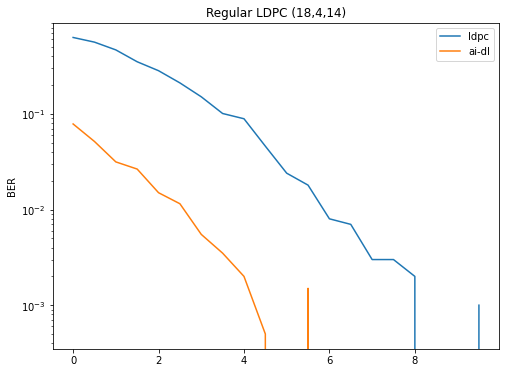

In [204]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

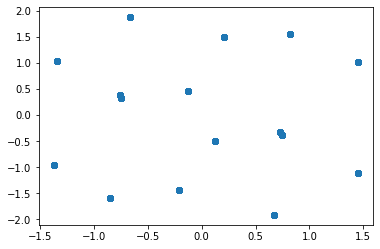

In [215]:
import matplotlib.pyplot as plt


plt.scatter(channel_x, channel_y)

plt.show()

In [ ]:
print(channel_x)
print(channel_y)
print (channel_x[1]**2+channel_y[1]**2)

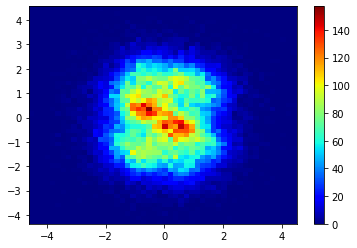

In [214]:
import matplotlib.pyplot as plt

#plt.scatter(channel_n_x, channel_n_y)
plt.hist2d(channel_n_x, channel_n_y, (50, 50), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

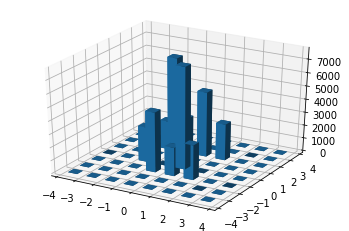

In [207]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
hist, xedges, yedges = np.histogram2d(channel_x, channel_y, bins=8, range=[[-4, 4], [-4, 4]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

In [140]:
def bits2int(a, axis=-1):
    return numpy.right_shift(numpy.packbits(a, axis=axis), 8 - a.shape[axis]).squeeze()


def row_bits2int(arr):
    n = arr.shape[1]  # number of columns
    # shift the bits of the first column to the left by n - 1
    a = arr[:, 0] << n - 1  

    for j in range(1, n):
        # "overlay" with the shifted bits of the next column
        a |= arr[:, j] << n - 1 - j  
    return a

In [ ]:
import numpy
training_input_message = numpy.random.randint(2**input_message_length, size=(1,NUM_OF_INPUT_MESSAGE*10))
training_input_message_one_hot = numpy.zeros((training_input_message.size, 2**input_message_length))
training_input_message_one_hot[numpy.arange(training_input_message.size),training_input_message] = 1
print(training_input_message_one_hot)
print (training_input_message_one_hot.shape)
print (training_input_message.shape)
print (training_input_message[0])
print (training_input_message_one_hot[0])
print (training_input_message_one_hot[1])

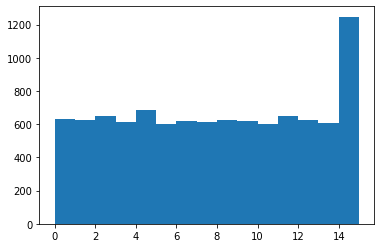

In [208]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message_decimal, bins = x_axis) 
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
[ 9 14  4  9  0  2 10 13 12 11  0  3  3 11 12  4  7 11 14  5 12 13  1 14
 15 12  2 12  2  0  0  1 10  7  1 11  7  9  9 11  3 10 13  1  6  2 15  9
  5  4  5  5 15  3  8  0 11  0  5  3 14 10  4  5 10 13 15  1  2  4  5  8
  0 13  6  3  7  9  6  5 13  2  2  4  6 13  9  2  2  7  8  1  8  7 11 10
 11 11  6  0]


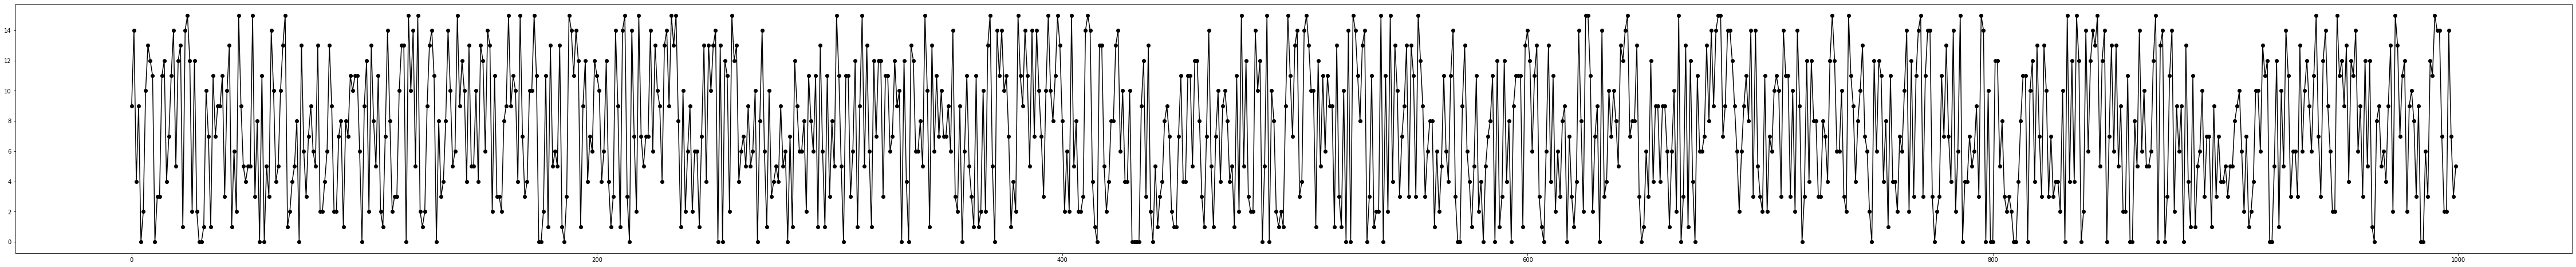

In [209]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:NUM_OF_INPUT_MESSAGE],training_input_message_decimal[:NUM_OF_INPUT_MESSAGE], '-ok')
print (x_axis[:100])
print(training_input_message_decimal[:100])


In [216]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))


In [217]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.29s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.57s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.82s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.06s
SNR: 0.000:
 -> BER: 0.08
 -> Total Time: 2.74s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.25s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.51s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.76s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.00s
SNR: 0.500:
 -> BER: 0.05
 -> Total Time: 2.52s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.24s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.49s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.74s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.00s
SNR: 1.000:
 -> BER: 0.04
 -> Total Time: 2.48s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.25s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.50s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

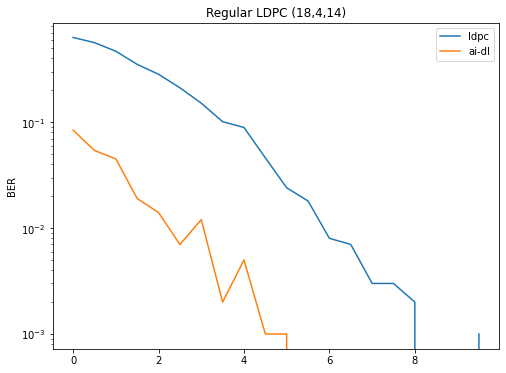

In [218]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()